# **Recurrent Neural Network - Stock Prediction**

Le but de cet exercice est de prédire le cours de l'action Google. Rien que ça. Plus exactement : on veut prédire le prix de l'action Google à j+1 en utilisant un certain nombre de jours précédents. Allez en route !

## **1. Import et preprocessing des données**

1. Récupérer les données de Google sur Yahoo!Finance (c'est la colonne "close" qui nous intéressera). Prendre tout l'historique (depuis le 19 août 2004)
2. Pour vous rafraîchir un peu la mémoire :
>- les charger en un objet série temporelle avec pandas,
>- modifier la fréquence pour être en "jours ouvrables"
>- afficher la série
3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée
4. Scaler vos données. Pour les réseaux récurrents et plus généralement lorsqu'on utilise des fonctions d'activation sigmoïde, on suggère d'utiliser la normalisation (min-max)
5. Transformer vos données de sorte qu'elles puissent servir pour entraîner un réseau, c'est-à-dire qu'on veut une matrice X d'inputs et un vecteur y de targets. Pour ça, vous devez vous demander, qu'est-ce que je veux prédire et avec quoi ?
6. Quelle est la dimension des inputs pour un [réseau récurrent de keras](https://keras.io/api/layers/recurrent_layers/) (simple, LSTM, GRU, peu importe) ? Agissez en conséquence...c'est niquel ça fera même la transition avec la suite : lisez la doc, vous allez faire un RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

# modif taille des figures
plt.rcParams["figure.figsize"] = (18,8)

In [2]:
# chargement des données et passage en timeseries
df = pd.read_csv("data/GOOG.csv",
                 usecols=['Date', 'Close'],
                 index_col='Date',
                 parse_dates=True)
df.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30'],
              dtype='datetime64[ns]', name='Date', length=4895, freq=None)

In [3]:
# fréquence jours ouvrables
df = df.asfreq('B', method='ffill')
df.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30'],
              dtype='datetime64[ns]', name='Date', length=5074, freq='B')

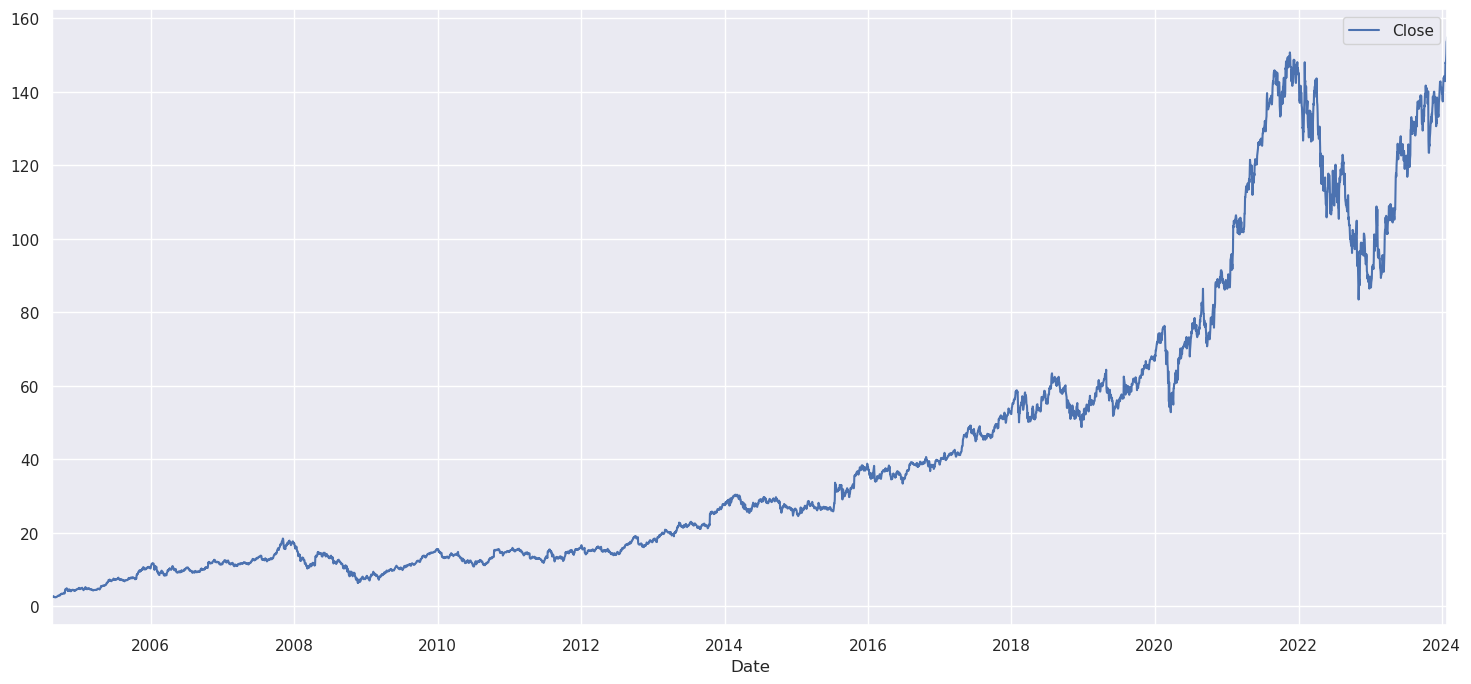

In [4]:
# affichage
df.plot();

In [5]:
# découpage train-test
# approche spécifique aux données temporelles
# on va cependant utiliser une méthode plus classique en ML/DL (voir plus bas)
train = df.loc[:"2023-09"]
test = df.loc["2023-10":]

print(train.shape, test.shape, df.shape)
print(train.index[-5:])
print(test.index[:5])

(4987, 1) (87, 1) (5074, 1)
DatetimeIndex(['2023-09-25', '2023-09-26', '2023-09-27', '2023-09-28',
               '2023-09-29'],
              dtype='datetime64[ns]', name='Date', freq='B')
DatetimeIndex(['2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06'],
              dtype='datetime64[ns]', name='Date', freq='B')


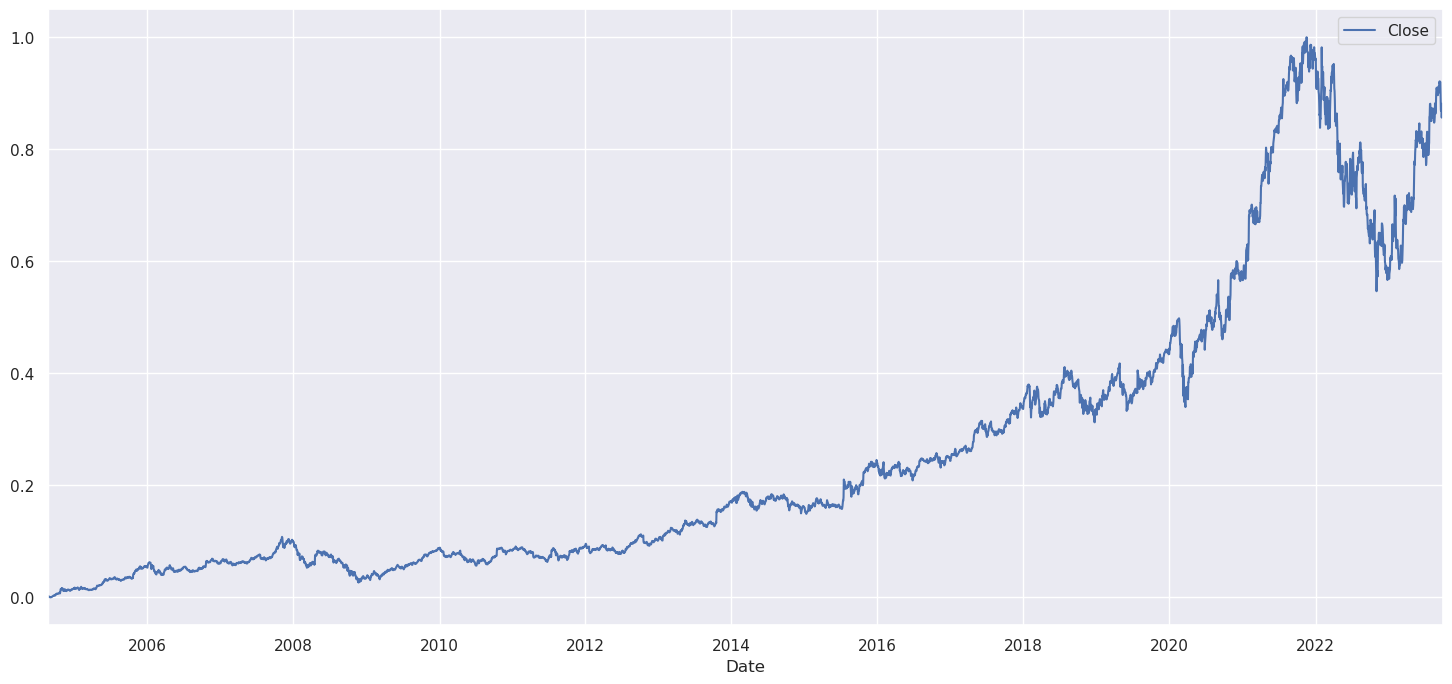

In [6]:
# normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc0 = MinMaxScaler().set_output(transform="pandas")
train = sc0.fit_transform(train)
test = sc0.transform(test)
train.plot();

In [7]:
# création d'une fonction qui construit X et y pour pouvoir utiliser un modèle ML/DL
# utilisation de n valeurs consécutives (n à fixer) pour prédire 1 valeur (la suivante)
from tqdm import tqdm

timesteps = 20

def build_train_test(data, timesteps=timesteps):
    X, y = [], []
    for i in tqdm(range(timesteps, data.shape[0])):
        y.append(data.iloc[i,0])
        X.append(data.iloc[i-timesteps:i,0].values)
    return np.array(X), np.array(y)

X, y = build_train_test(df)
X_train0, y_train0 = build_train_test(train)
X_test0, y_test0 = build_train_test(test)
X.shape, y.shape, X_train0.shape, X_test0.shape, y_train0.shape, y_test0.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 9263.83it/s]


((5054, 20), (5054,), (4967, 20), (67, 20), (4967,), (67,))

In [8]:
# nouveau découpage train-test
# avantage = on a des données réparties aléatoirement sur toute la période 
# inconvénient = on peut moins bien visualiser les données sur un graphique
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5003, 20), (51, 20), (5003,), (51,))

In [9]:
# normalisation MinMax à refaire sur le nouveau découpage
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# Ajout d'une 3ème dimension à X_train
X_train0 = np.expand_dims(X_train0, axis=2)
X_test0  = np.expand_dims(X_test0, axis=2)
X_train  = np.expand_dims(X_train, axis=2)
X_test   = np.expand_dims(X_test, axis=2)

# Pas obligé mais on peut aussi le faire sur y pour simplifier les calculs des métriques
y_test0  = np.expand_dims(y_test0, axis=1)
y_test   = np.expand_dims(y_test, axis=1)

print(X_train0.shape, X_test0.shape, y_train0.shape, y_test0.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4967, 20, 1) (67, 20, 1) (4967,) (67, 1)
(5003, 20, 1) (51, 20, 1) (5003,) (51, 1)


## **2. Construction du réseau**

1. Continuer de regarder un peu la doc `keras` sur les RNN pour savoir quelles couches utiliser
2. En reprenant toujours les mêmes étapes (initialisation, ajout de couches cachées, couche de sortie, paramètres d'entraînement, entraînement), construire un RNN comprenant plusieurs couches LSTM empilées.  
Ne pas oublier de gérer le sur-apprentissage s'il y en a...

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU

# Initialisation
rnn = Sequential()
# 1ère couche LSTM
rnn.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2])))
# Output
rnn.add(Dense(units=1))
# Paramètres d'entraînement
rnn.compile(optimizer='adam', loss='mse')
# Structure du modèle
print(rnn.summary())
# Entraînement
rnn.fit(X_train, y_train, epochs=50, batch_size=32)

2024-02-01 16:13:58.697560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3871 (15.12 KB)
Trainable params: 3871 (15.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
157/157 [==============================] - 3s 7ms/step - loss: 2919.3916
Epoch 2/50
157/157 [==============================] - 1s 6ms/step - loss: 2397.6472
Epoch 3/50
157/157 [==============================] - 1s 6ms/step - loss: 2140.5903
Epoch 4/50
157/157 [==============================] - 1s 6ms/step - loss: 1959.7250
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 182

In [12]:
rnn0 = Sequential()
rnn0.add(LSTM(units=30, input_shape=(X_train0.shape[1], X_train0.shape[2])))
rnn0.add(Dense(units=1))
rnn0.compile(optimizer='adam', loss='mse')
rnn0.fit(X_train0, y_train0, epochs=50, batch_size=32)

Epoch 1/50
156/156 [==============================] - 3s 7ms/step - loss: 0.0063
Epoch 2/50
156/156 [==============================] - 1s 6ms/step - loss: 2.2841e-04
Epoch 3/50
156/156 [==============================] - 1s 7ms/step - loss: 2.0930e-04
Epoch 4/50
156/156 [==============================] - 1s 7ms/step - loss: 1.9400e-04
Epoch 5/50
156/156 [==============================] - 1s 7ms/step - loss: 1.8934e-04
Epoch 6/50
156/156 [==============================] - 1s 8ms/step - loss: 1.7874e-04
Epoch 7/50
156/156 [==============================] - 1s 7ms/step - loss: 1.7364e-04
Epoch 8/50
156/156 [==============================] - 1s 6ms/step - loss: 1.6719e-04
Epoch 9/50
156/156 [==============================] - 1s 7ms/step - loss: 1.5495e-04
Epoch 10/50
156/156 [==============================] - 1s 7ms/step - loss: 1.5887e-04
Epoch 11/50
156/156 [==============================] - 1s 6ms/step - loss: 1.4951e-04
Epoch 12/50
156/156 [==============================] - 1s 6ms/step 

In [13]:
def metrics(pred, real):
    RMSE = np.sqrt(((pred-real)**2).mean())
    nRMSE = RMSE/np.mean(real)
    MAE = (np.abs(pred-real)).mean()
    nMAE = MAE/np.mean(real)
    print(f"{RMSE = }\n{nRMSE = }\n{MAE = }\n{nMAE = }")

metrics(rnn.predict(X_test), y_test)
metrics(sc0.inverse_transform(rnn0.predict(X_test0)), sc0.inverse_transform(y_test0))

2/2 [==============================] - 0s 4ms/step
RMSE = 2.943159059641512
nRMSE = 0.07151611136644825
MAE = 1.4914674474517233
nMAE = 0.03624131414915164
3/3 [==============================] - 0s 3ms/step
RMSE = 1.800246591376721
nRMSE = 0.01296744090543816
MAE = 1.4126126574451965
nMAE = 0.010175256681744946


2/2 [==============================] - 0s 3ms/step


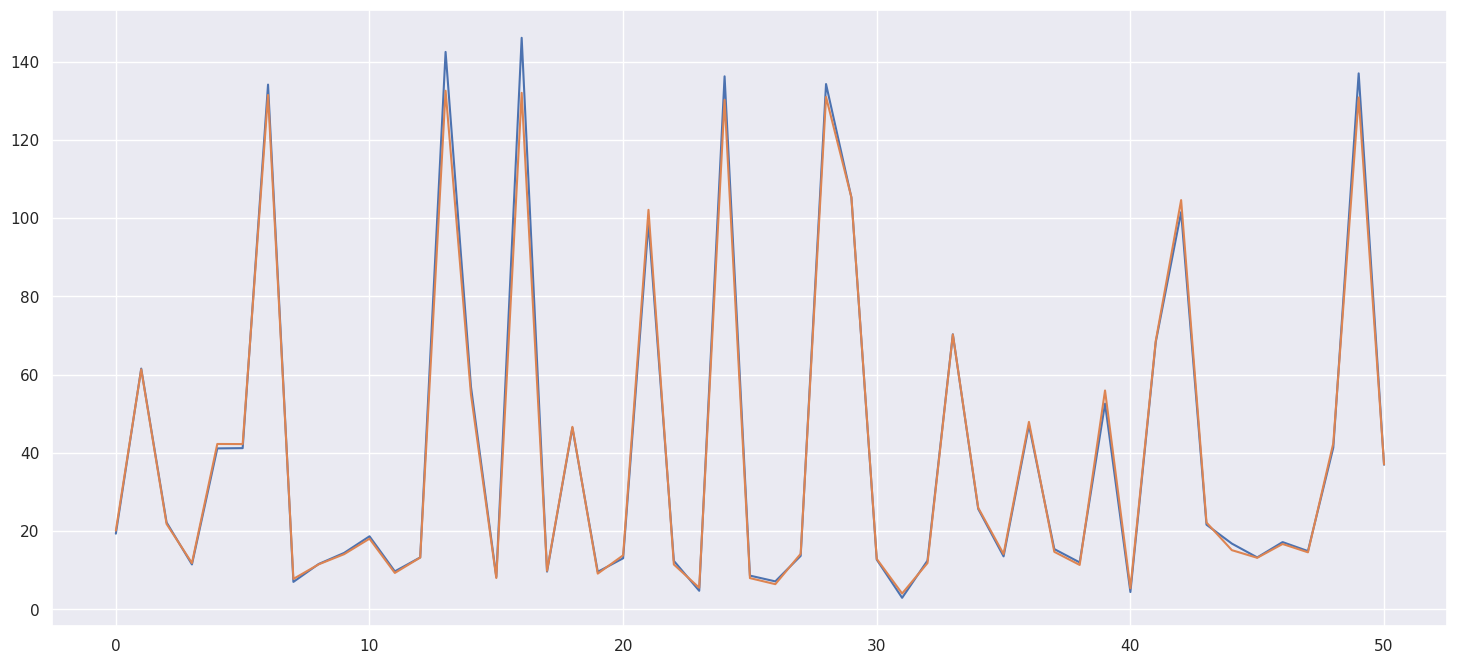

In [14]:
plt.plot(y_test)
plt.plot(rnn.predict(X_test));

3/3 [==============================] - 0s 3ms/step


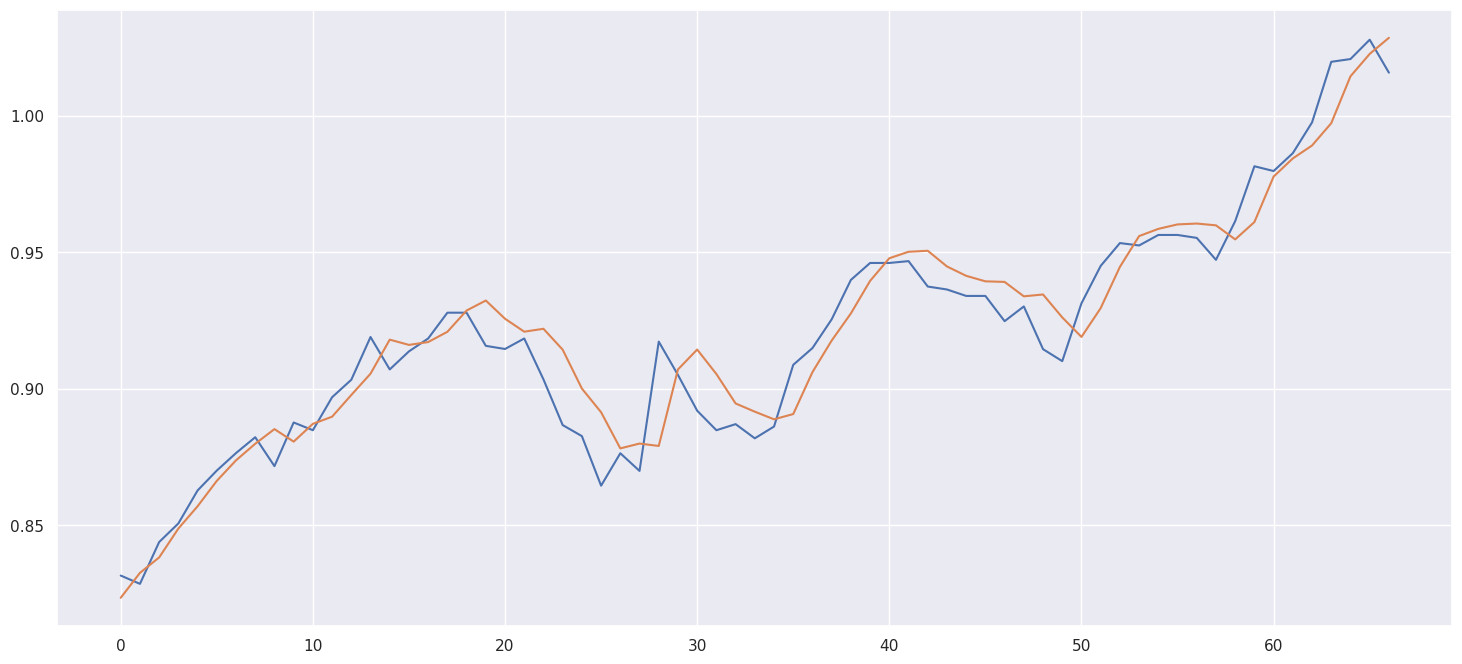

In [15]:
plt.plot(y_test0)
plt.plot(rnn0.predict(X_test0));

3/3 [==============================] - 0s 3ms/step


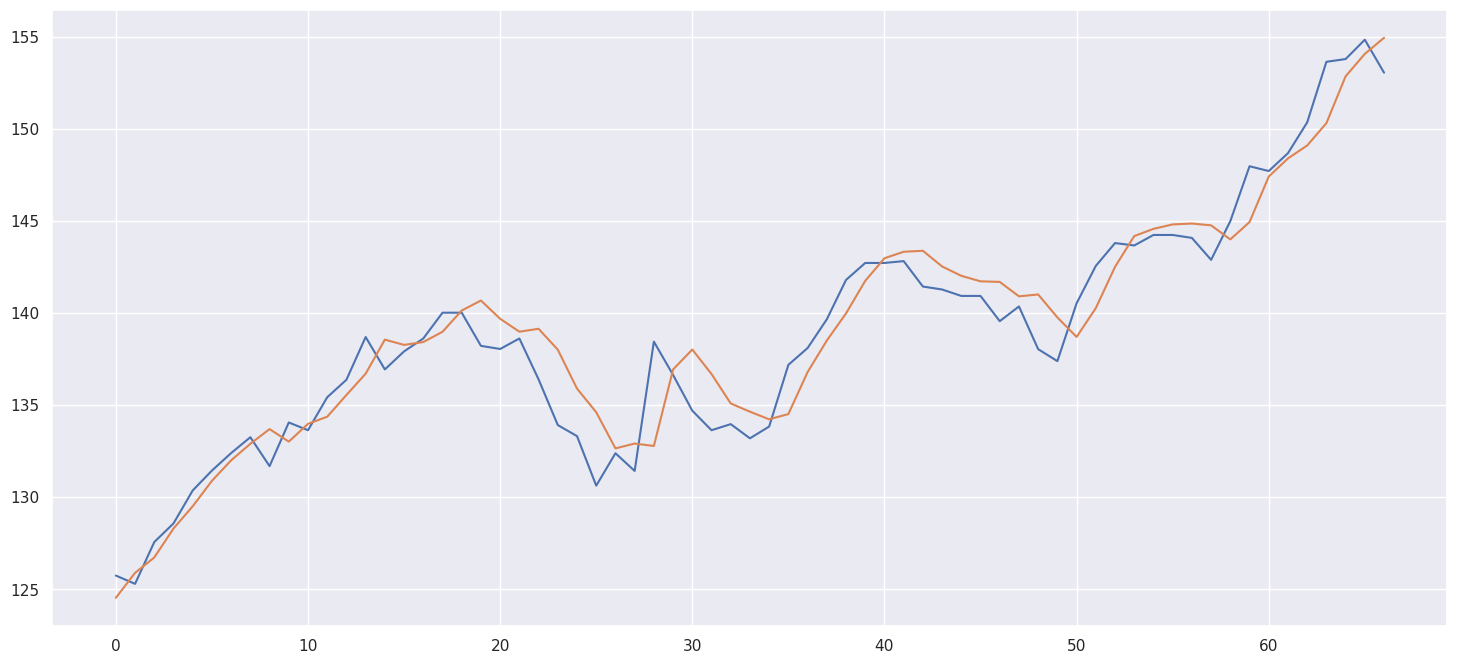

In [16]:
plt.plot(sc0.inverse_transform(y_test0))
plt.plot(sc0.inverse_transform(rnn0.predict(X_test0)));

## **3. Prédiction, évaluation et visualisation**

On va essayer dans cette partie de prédire les 2 derniers mois.

**Première approche :** une première méthode est de prédire chaque jour à partir des dernières vraies valeurs. Cela a du sens puisque notre modèle est construit pour ça : prédire la valeur de l'action à j+1 à partir d'un nombre de jours précédents fixés. En revanche cela veut dire qu'on utilise à chaque fois les vraies valeurs de l'échantillon test pour prédire la suivante. Pour essayer d'être plus clair :  
>- on a un modèle entraîné avec les données jusqu'au dernier jour de l'échantillon d'entraînement
>- notre modèle est fait pour prédire un jour à partir des précédents, donc on va prédire à chaque fois à partir des vraies valeurs observées la valeur suivante.
>
> Ce qu'on peut reprocher à cette méthode c'est de ne pas utiliser les nouvelles infos dans la construction du modèle mais uniquement pour la prédiction. Ça a un petit côté paradoxal mais en même temps on a pas forcément envie de réentraîner notre modèle tous les jours avec juste une seule valeur en plus.
>
>1. Le premier travail va être de formater les inputs de test pour qu'ils soient au même format que ceux de l'entraînement du modèle. Il faut donc répéter les opérations qu'on a faites pour le train. Avec quelques modifications quand même. hésitez pas à prendre un papier un crayon si ça chauffe trop...
>>- définir un objet `inputs` qui contient toutes les valeurs dont vous aurez besoin (donc les données du test + les n dernières valeurs du train nécessaires à la prédiction des n premières valeurs du test). Vous pouvez pour ça utiliser certaines méthodes des objets datetime de pandas.
>>- une fois que c'est fait, il vous reste plus qu'à normaliser et reconstruire votre `X_test` de la même manière que votre `X_train`
>2. Évaluer les prédictions avec une ou plusieurs métriques adaptées
>3. Afficher les prédictions sur un beau graphique

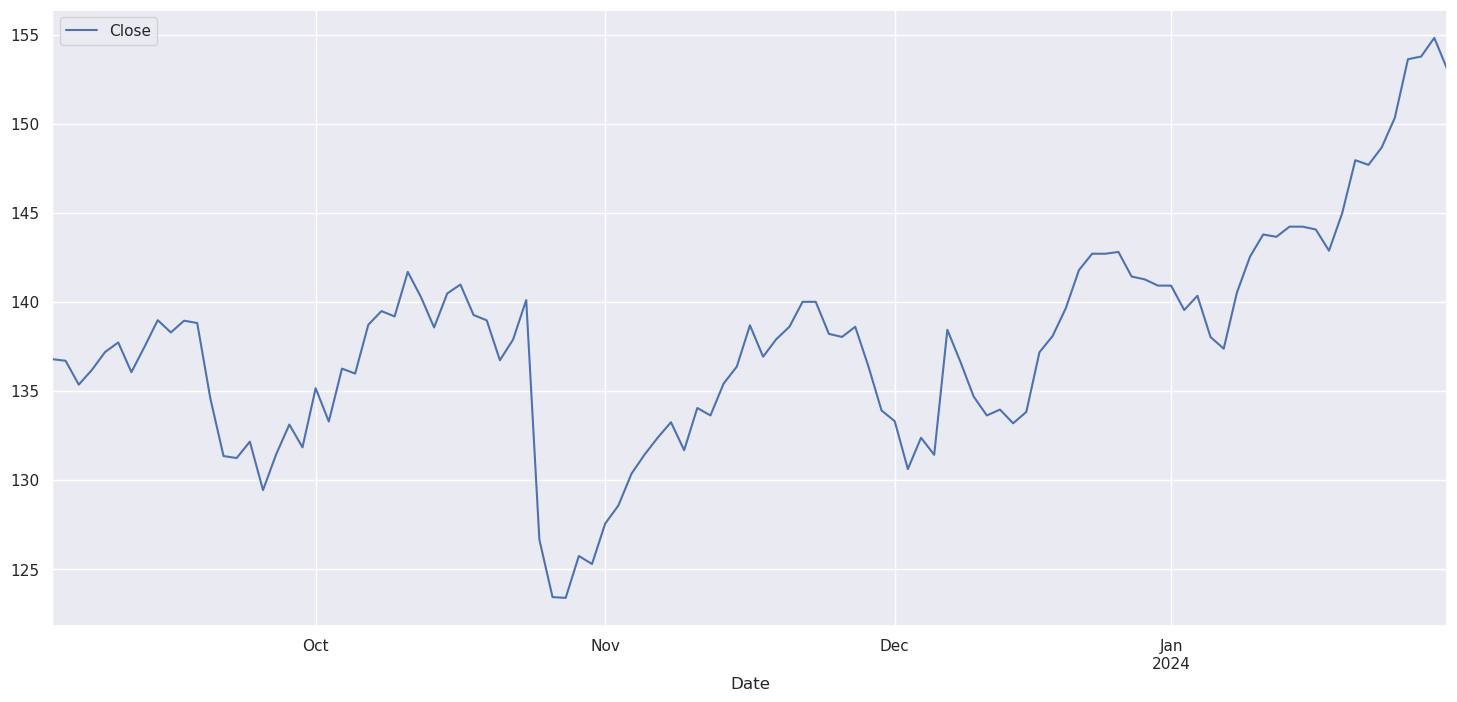

In [17]:
inputs = df[pd.date_range(end=test.index[0], periods=timesteps+1, freq='B')[0]:]
inputs.plot();

In [18]:
inputs = sc0.transform(inputs)
X_inputs, y_inputs = build_train_test(inputs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 8501.18it/s]


In [19]:
X_inputs  = np.expand_dims(X_inputs, axis=2)
X_inputs.shape

(87, 20, 1)

In [20]:
metrics(rnn0.predict(X_inputs), y_inputs)

3/3 [==============================] - 0s 3ms/step
RMSE = 0.058335939683094626
nRMSE = 0.06368700774787987
MAE = 0.0453256470614252
nMAE = 0.04948330053925898


3/3 [==============================] - 0s 3ms/step


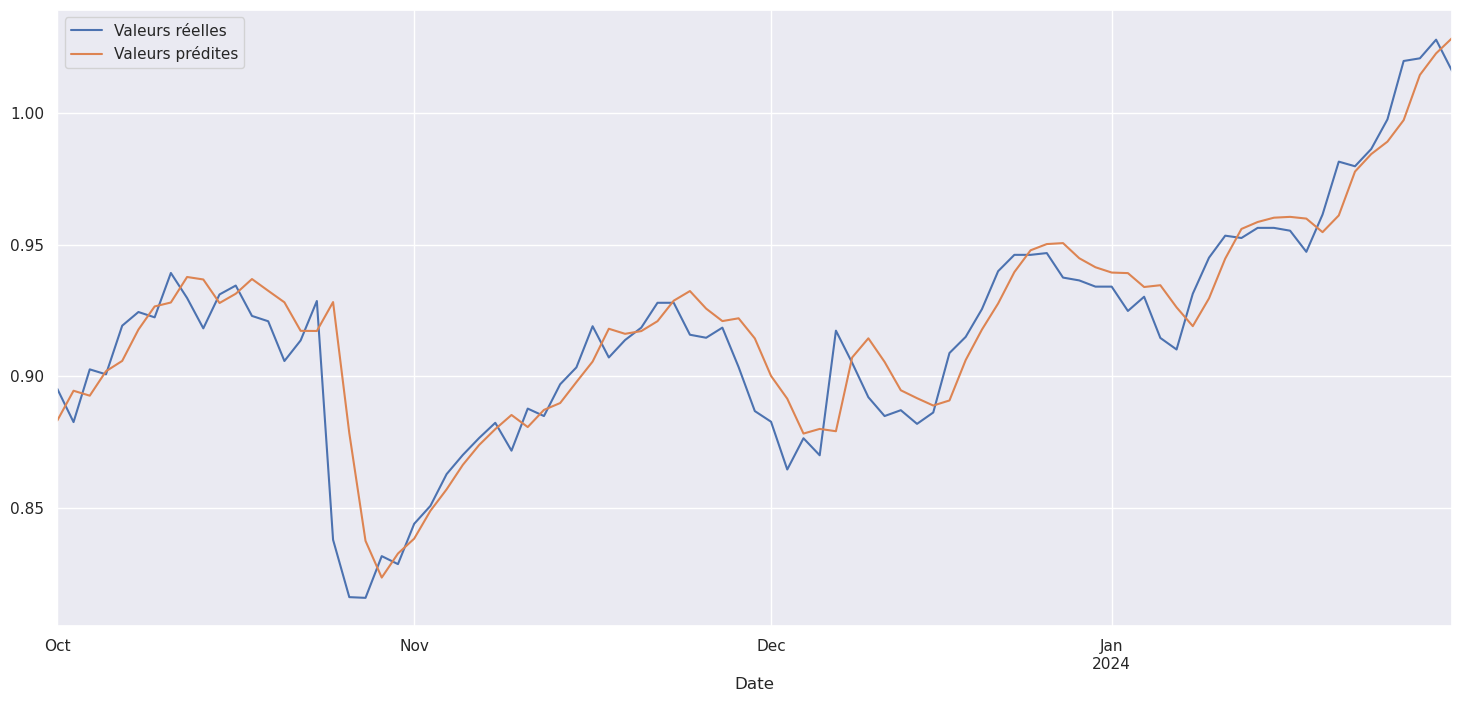

In [21]:
y_df = test.copy().rename(columns={'Close':'Valeurs réelles'})
y_df['Valeurs prédites'] = rnn0.predict(X_inputs)
y_df.plot();

**Deuxième approche :** la deuxième possibilité consiste à prédire toutes la période de test connaissant les vraies données uniquement au dernier jour de l'échantillon d'entraînement. Cela pourrait avoir du sens si on veut savoir comment va évoluer la tendance à moyen terme (ou en tout cas à plus que j+1). L'idée est :
>- de prédire le 1er jour de l'échantillon de test et partir des jours précédents
>- puis le 2nd jour en utilisant la prédiction obtenue pour le premier jour et les jours précédents
>- etc...
>
> Le modèle qu'on a construit est prévu pour ne prédire qu'à un jour donc on réutilise la prédiction comme input pour la prédiction du jour suivant. Le problème est qu'on multiplie ainsi les erreurs qui s'accumule un jour après l'autre. Cette méthode ne sera donc a priori pas très convaincante ou en tout cas pas sur une longue période...mais on va le faire quand même !
>
>1. On va de nouveau formater les inputs mais différement bien sûr.
>>- définir un objet `inputs` qui contient toutes les n dernières valeurs du train nécessaires à la prédiction
>>- faire la prédiction pour le 1er jour
>>- ajouter cette prédiction dans votre objet `inputs` et supprimer la 1ère valeur dont on aura plus besoin
>>- faire la prédiciton du second jour puis l'insérer dans votre `inputs`
>>- etc jusqu'à avoir prédit toutes les valeurs de 2022
>2. Évaluer et afficher les prédictions

In [22]:
### ça marche pas donc on le fait pas, pas de à perdre

**Troisième approche :** après l'échec de la deuxième option, on va mettre en place une 3ème. L'objectif est de construire un modèle RNN (many-to-many) qui pour une séquence d'entrée (longueur à choisir) va prédire une séquence d'un mois (c'est-à-dire 20 jours ouvrés).

In [23]:
# Création de la structure des données
timesteps = 100
nbdays = 20 
X_train = []
y_train = []

for i in tqdm(range(timesteps, train.shape[0]-nbdays)):
    X_train.append(train.iloc[i-timesteps:i, 0])
    y_train.append(train.iloc[i:i+nbdays, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.expand_dims(X_train, axis=2)
print(X_train.shape, y_train.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4867/4867 [00:01<00:00, 4852.10it/s]


(4867, 100, 1) (4867, 20)


In [24]:
# Initialisation
rnn2 = Sequential()

# 1ère couche LSTM
rnn2.add(GRU(units=20,
             input_shape=(X_train.shape[1], X_train.shape[2]),
             return_sequences=True,
             unroll=True)) #unroll paramètre pour CPU

# 2ème couche LSTM
rnn2.add(LSTM(units=30,
              unroll=True)) #unroll paramètre pour CPU

# Output
rnn2.add(Dense(units=nbdays))

# Paramètres d'entraînement
rnn2.compile(optimizer='adam', loss='mse')

# Structure du modèle
print(rnn2.summary())

# Entraînement
rnn2.fit(X_train, y_train, epochs=30, batch_size=32, workers=-1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 20)           1380      
                                                                 
 lstm_2 (LSTM)               (None, 30)                6120      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
Total params: 8120 (31.72 KB)
Trainable params: 8120 (31.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
153/153 [==============================] - 31s 29ms/step - loss: 0.0174
Epoch 2/30
153/153 [==============================] - 5s 31ms/step - loss: 6.6720e-04
Epoch 3/30
153/153 [==============================] - 5s 32ms/step - loss: 6.2820e-04
Epoch 4/30
153/153 [====

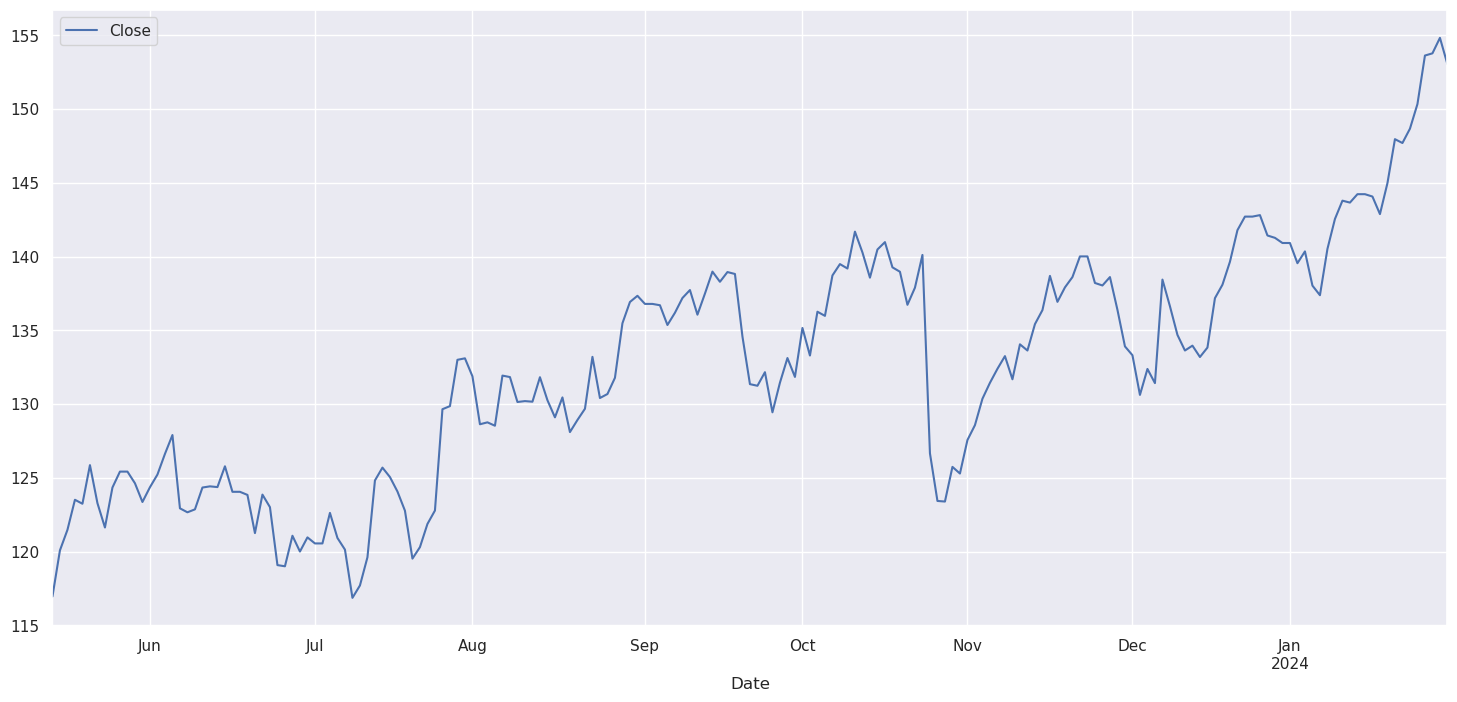

In [25]:
inputs = df[pd.date_range(end=test.index[0], periods=timesteps+1, freq='B')[0]:]
inputs.plot();

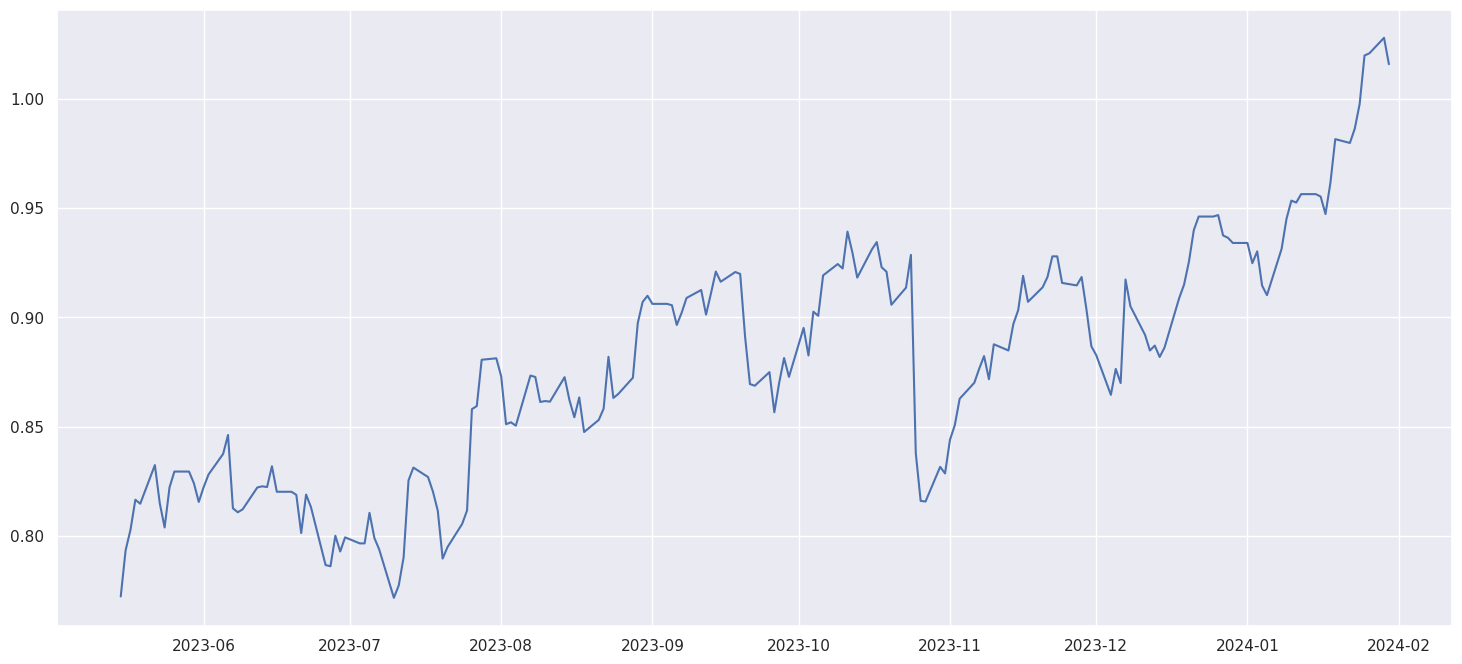

In [26]:
inputs = sc0.transform(inputs)
plt.plot(inputs);

In [27]:
# Création de la structure des données
timesteps = 100
nbdays = 20 
X_test = []
y_test = []

for i in tqdm(range(timesteps, len(inputs)-nbdays)):
    X_test.append(inputs.iloc[i-timesteps:i, 0])
    y_test.append(inputs.iloc[i:i+nbdays, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.expand_dims(X_test, axis=2)

print(X_test.shape, y_test.shape, inputs.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 4280.81it/s]

(67, 100, 1) (67, 20) (187, 1)


In [28]:
metrics(sc0.inverse_transform(rnn2.predict(X_test)), sc0.inverse_transform(y_test))

3/3 [==============================] - 4s 11ms/step
RMSE = 6.721146609216334
nRMSE = 0.04915827103346033
MAE = 5.147134852183419
nMAE = 0.03764599477155344


In [29]:
y_pred, y_test = sc0.inverse_transform(rnn2.predict(X_test)), sc0.inverse_transform(y_test)

3/3 [==============================] - 0s 10ms/step


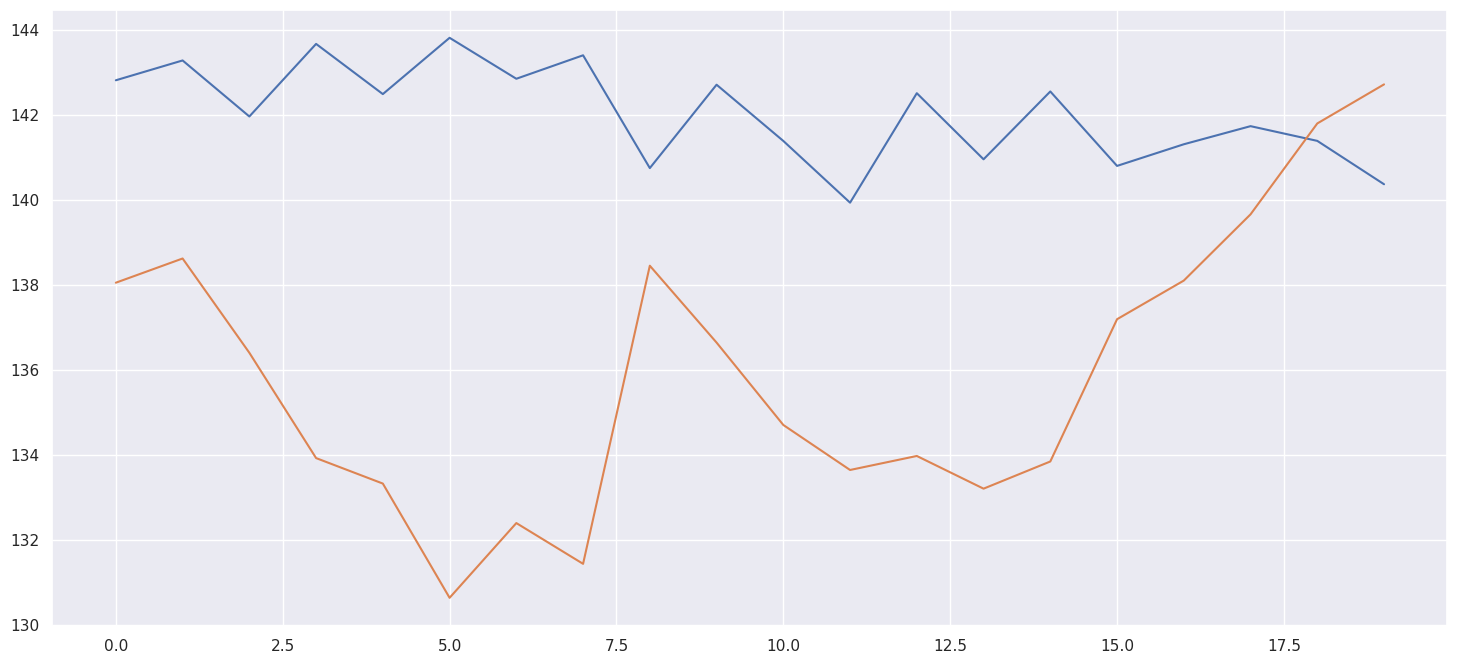

In [30]:
plt.plot(y_pred[40])
plt.plot(y_test[40]);

## **4. Amélioration du modèle**

En revenant sur la première approche, essayer d'amélorier le modèle.

Quelques pistes qui peuvent évidemment être combinées mais tout ça étant coûteux en temps, vous ne pourrez pas tout tester :
- Plus de données, quand c'est possible cf point 5
- Augmenter le nombre de "timesteps" pour regarder plus loin dans le passé
- Ajouter d'autres variables : par exemple on pourrait ajouter des actions d'autres entreprises dont l'action pourrait être corrélée à celle de Google
- Compléxifier le réseau : plus de couches/neurones
- Ajustement des hyperparamètres

## **5. Ajout de variables supplémentaires**

Comme évoqué, on pourrait vouloir ajouter d'autres variables pour améliorer les performances de notre modéle. Dans cette partie, il s'agit de mettre en oeuvre un RNN avec plusieurs variables. Sans aller chercher l'action d'une autre entreprise des GAFA par exemple, on va se contenter pour simplifier ici d'uitiliser les autres variables disponibles dans le dataset (Open, High et Low).

1. À vous de modifier votre code pour prendre en compte dans votre modèle les 4 informations Open, High, Low et Close.
2. Comparer les prédictions obtenues (et les temps d'exécution !)

In [31]:
df = pd.read_csv('data/GOOG.csv', usecols=['Date','Open', 'High', 'Low', 'Close'], index_col='Date', parse_dates=True)
df = df.asfreq('B', method="ffill")
df.tail()

,Open,High,Low,Close
Date,,,,
2024-01-24,150.289993,151.570007,149.839996,150.350006
2024-01-25,151.740005,154.759995,151.220001,153.639999
2024-01-26,152.869995,154.110001,152.800003,153.789993
2024-01-29,153.639999,155.199997,152.919998,154.839996
2024-01-30,154.009995,155.039993,152.774994,153.050003


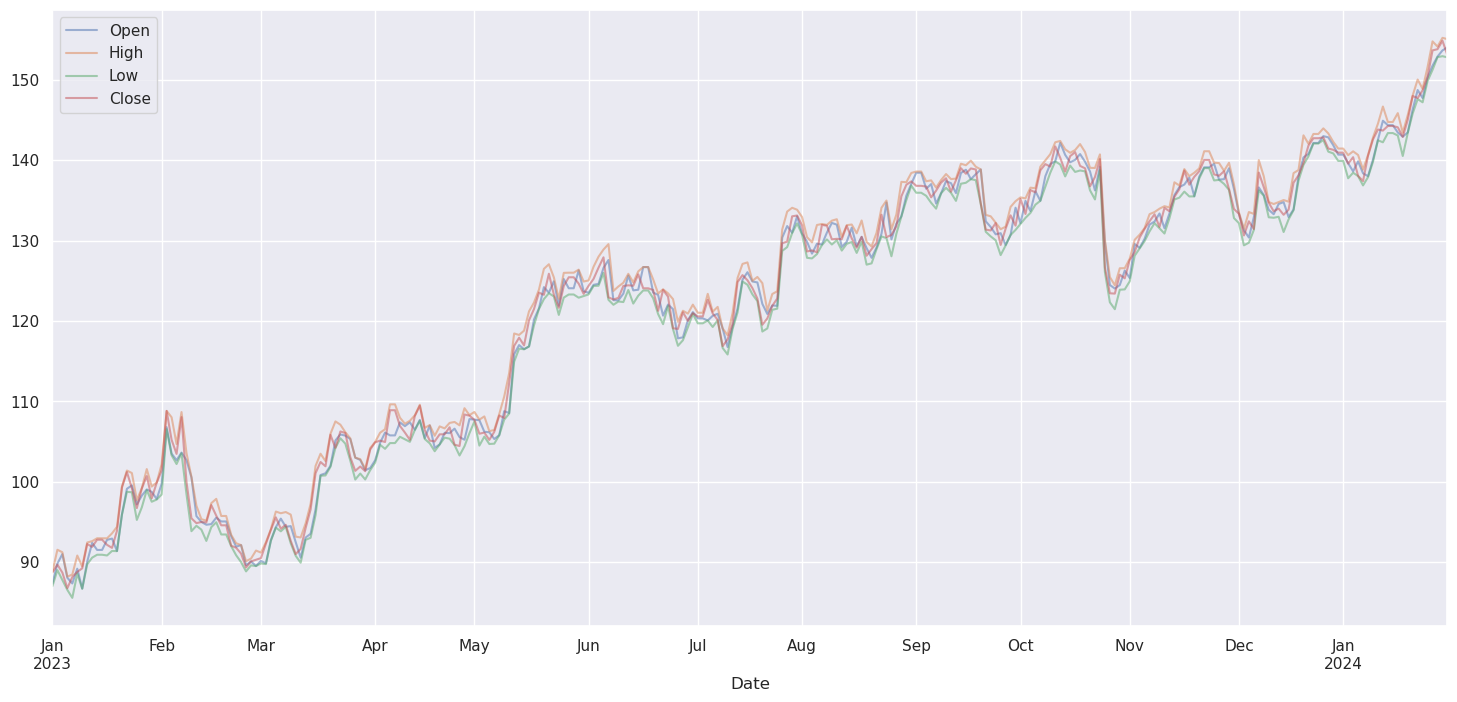

In [32]:
df['2023':].plot(alpha=0.5);

In [33]:
# train et test sets
train = df.loc[:'2023-06']
test = df.loc['2023-07':]
print(df.shape, train.shape, test.shape)

(5074, 4) (4922, 4) (152, 4)


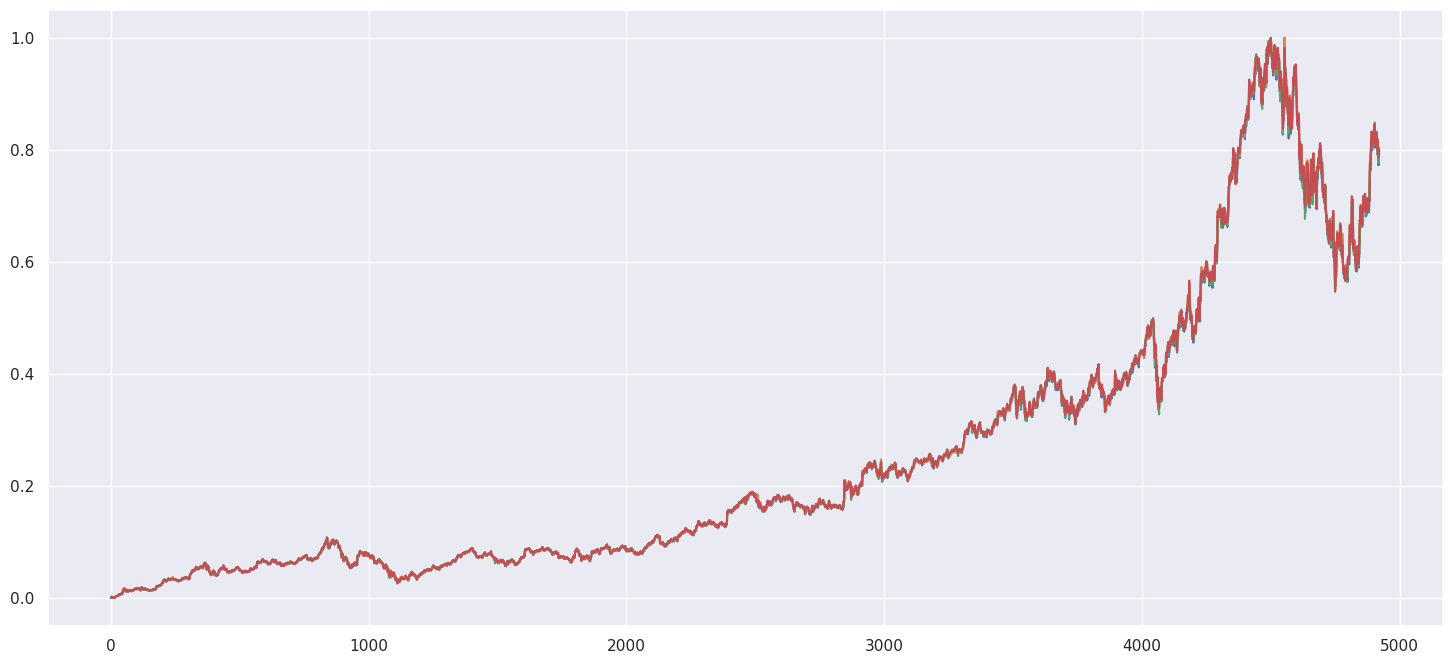

In [34]:
# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
plt.plot(train);

In [35]:
# Création de la structure des données avec un nombre fixé n de timesteps
# et 1 output c'est à dire qu'on va prédire la valeur de l'action pour 1 jour
# à partir des n précédents
timesteps = 30
X_train = []
y_train = []

for i in range(timesteps, train.shape[0]):
    y_train.append(train[i, 3])
    X_train.append(train[i-timesteps:i, :])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(4892, 30, 4) (4892,)


In [36]:
# Modèle RNN
model = Sequential()
model.add(LSTM(units = 30, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
153/153 [==============================] - 3s 9ms/step - loss: 0.0058
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 2.4210e-04
Epoch 3/50
153/153 [==============================] - 1s 8ms/step - loss: 1.9249e-04
Epoch 4/50
153/153 [==============================] - 1s 8ms/step - loss: 1.6874e-04
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 1.4941e-04
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 1.3764e-04
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 1.2390e-04
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 1.2203e-04
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 1.1840e-04
Epoch 10/50
153/153 [==============================] - 1s 8ms/step - loss: 1.1212e-04
Epoch 11/50
153/153 [==============================] - 1s 9ms/step - loss: 1.1971e-04
Epoch 12/50
153/153 [==============================] - 1s 8ms/step 

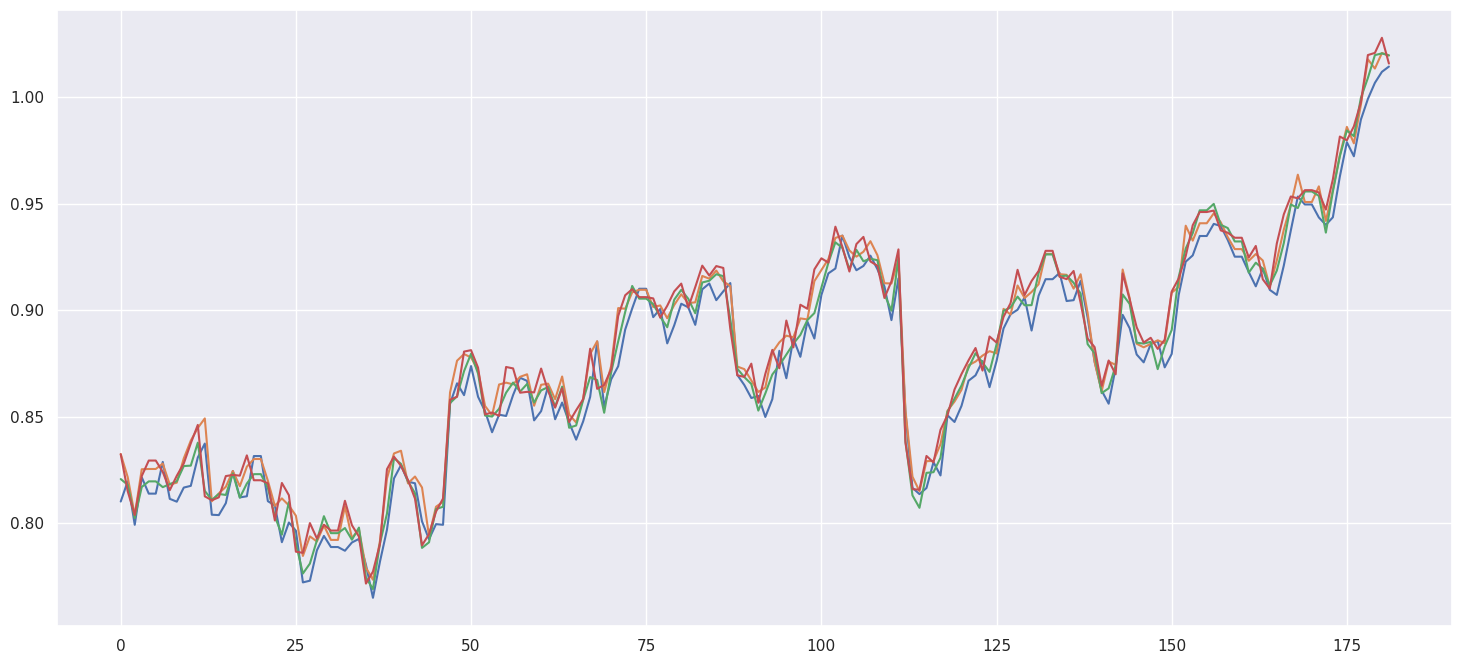

In [37]:
inputs = df[pd.date_range(end=test.index[0], periods=timesteps+1, freq='B')[0]:]
inputs = sc.transform(inputs)
plt.plot(inputs);

In [38]:
X_test = []
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i,:])
X_test = np.array(X_test)
print(X_test.shape)

(152, 30, 4)


In [39]:
#predictions
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [40]:
# Le sc a été fitté sur une matrice a 4 colonnes donc pour revenir aux vraies valeurs grace à inverse_transform il faut :
# - soit créer une matrice intermédiaire à 4 colonnes avec y_pred en 4ème colonne (colonne Close), faire l'inverse_transform puis récupérer les valeurs
# - soit fitter un nouveau transformer uniquement sur la colonne Close du train et faire l'inverse_transform sur y_pred
mat = np.zeros((y_pred.shape[0], 4))
mat[:, 3] = y_pred[:,0]
mat = sc.inverse_transform(mat)
y_pred = mat[:,3]

In [42]:
# Évaluation : RMSE et RMSE normalisé (ou relatif)
metrics(y_pred, test.Close.values)

RMSE = 2.916792387045194
nRMSE = 0.021651218912759874
MAE = 2.369766868142517
nMAE = 0.01759067304969759
